In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [16,10]
# %config InlineBackend.figure_format = 'svg'

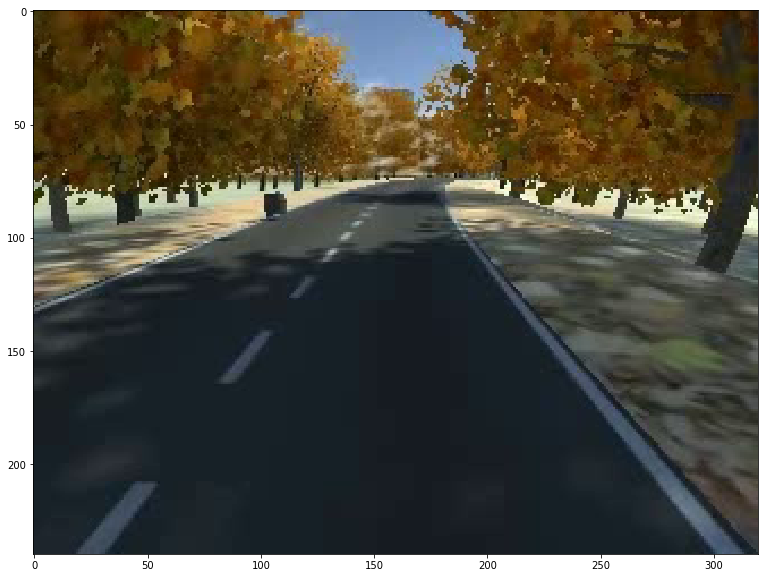

In [3]:
img = cv2.imread('images/sample_shadow.png')

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

- Define function that do the following things:
    - Crop the image for ROI
    - Transform the image base on the `shrink_ratio`

In [4]:
def get_bird_view(img, shrink_ratio,dsize=(480,320)):
    height, width = img.shape[:2]
    SKYLINE = int(height*0.55)

    roi = img.copy()
    cv2.rectangle(roi, (0, 0), (width, SKYLINE), 0, -1)

    dst_width,dst_height = dsize

    src_pts = np.float32([[0, SKYLINE], [width, SKYLINE], [0, height], [width, height]])
    dst_pts = np.float32([[0, 0], [dst_width, 0], [dst_width*shrink_ratio, dst_height], [dst_width*(1-shrink_ratio), dst_height]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    dst = cv2.warpPerspective(roi, M, dsize)

    return dst

In [5]:
def inv_bird_view(img,stretch_ratio,dsize=(320,240)):
    height, width = img.shape[:2]

    dst_width,dst_height = dsize

    SKYLINE = int(dst_height*0.55)

    src_pts = np.float32([[0,0],[width,0],[width*stretch_ratio,height],[width*(1-stretch_ratio),height]])
    dst_pts = np.float32([[0,SKYLINE],[dst_width,SKYLINE],[0,dst_height],[dst_width,dst_height]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    dst = cv2.warpPerspective(img, M, dsize)

    return dst

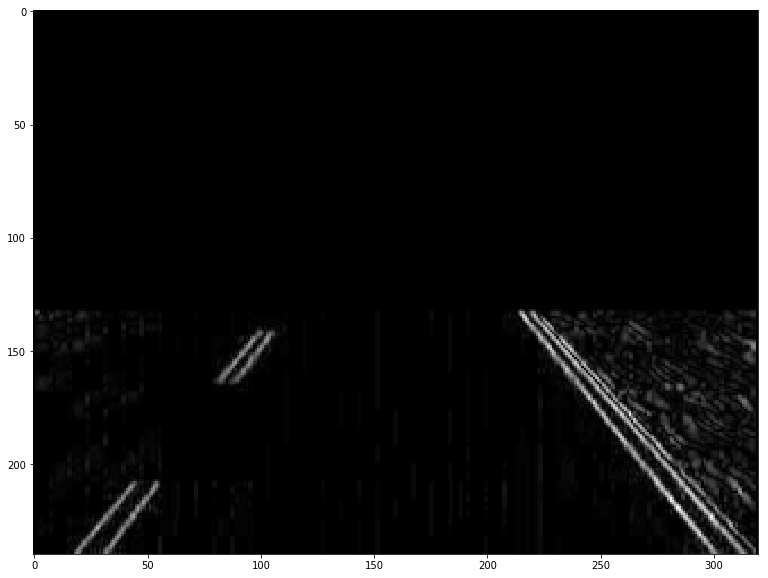

In [6]:
roi = img.copy()
height,width=roi.shape[:2]
cv2.rectangle(roi,(0,0),(width,int(height*0.55)),0,-1) # crop the image

hls = cv2.cvtColor(roi,cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# Sobel x direction
sobel = cv2.Sobel(l_channel,cv2.CV_64F,1,0)
# sobel = cv2.Laplacian(l_channel,cv2.CV_64F)
abs_sobel = np.absolute(sobel) # absolute all negative gradient values

l_ret, l_thresh = cv2.threshold(abs_sobel, 75, 255, cv2.THRESH_BINARY)

plt.imshow(abs_sobel,cmap='gray')
plt.show()

### Create the sky view image

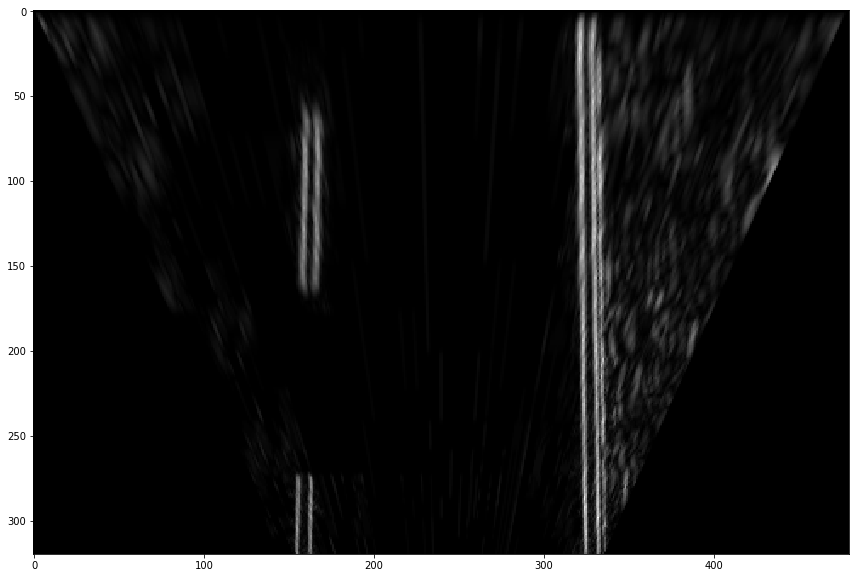

In [7]:
bird_view = get_bird_view(abs_sobel,0.30).astype(np.uint8)
plt.imshow(bird_view,cmap='gray')
plt.show()

### Calculate the distribution of the pixels

In [8]:
def get_hist(img):
    hist = np.sum(img, axis=0)
    return hist

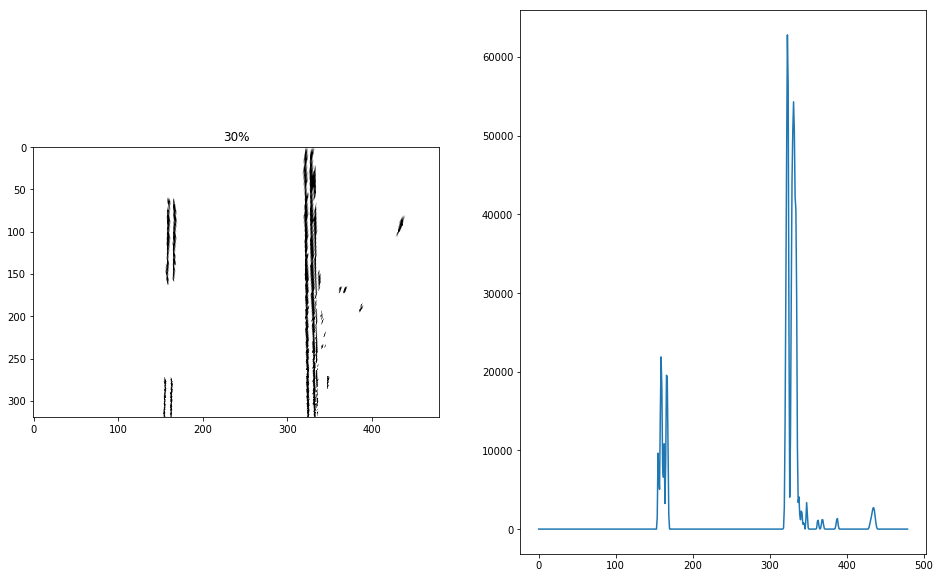

In [9]:
ratio = 0.3

bird_view = get_bird_view(l_thresh,ratio)
bird_view = bird_view.astype(np.uint8)
label = '{}%'.format(int(ratio*100))

ax = plt.subplot(121)
ax.set_title(label)
plt.imshow(bird_view,cmap='binary')

ax = plt.subplot(122)
# plt.hist(bird_view.ravel(),255,[1,254])
s_hist = np.sum(bird_view,axis=0)
plt.plot(s_hist)

plt.show()

### Sliding Window Algorithm and Curve Plotting

In [10]:
# x = ay + b
left_a, left_b = [], []
right_a, right_b = [], []


def sliding_window(img, nwindows=16, margin=20, minpix=1, draw_windows=True, left_color=(0, 0, 255), right_color=(0, 255, 0), thickness=1):
    global left_a, left_b, right_a, right_b
    left_fit_ = np.empty(2)
    right_fit_ = np.empty(2)
    # I haven't understood this line of code
    out_img = np.dstack((img, img, img))*255

    s_hist = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(s_hist.shape[0]/2)
    leftx_base = np.argmax(s_hist[:midpoint])
    rightx_base = np.argmax(s_hist[midpoint:]) + midpoint

    # set the height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high), left_color, thickness)
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high), right_color, thickness)

        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # if you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # concatenate the arrays of indices ???
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx) == 0 or len(lefty) == 0:
        left_fit = np.array([0, 0])
    else:
        left_fit = np.polyfit(lefty, leftx, 1)

    if len(rightx) == 0 or len(righty) == 0:
        right_fit = np.array([0, 0])
    else:
        right_fit = np.polyfit(righty, rightx, 1)

    left_a.append(left_fit[0])
    left_b.append(left_fit[1])

    right_a.append(right_fit[0])
    right_b.append(right_fit[1])

    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])

    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])

    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    print(img.shape[:2])
    
    left_fitx = left_fit_[0] * ploty + left_fit_[1]
    right_fitx = right_fit_[0] * ploty + right_fit_[1]

    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

(320, 480)


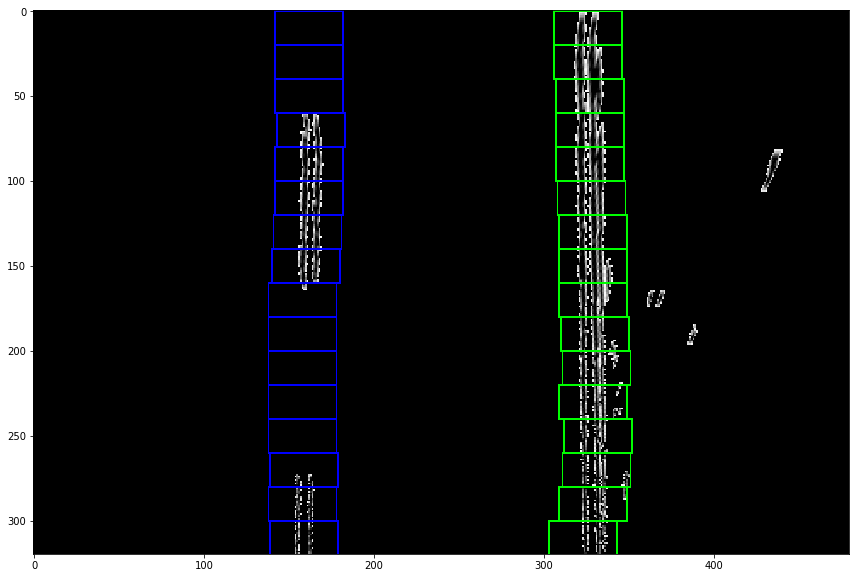

In [11]:
s_window, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty = sliding_window(bird_view)
plt.imshow(s_window)
plt.show()

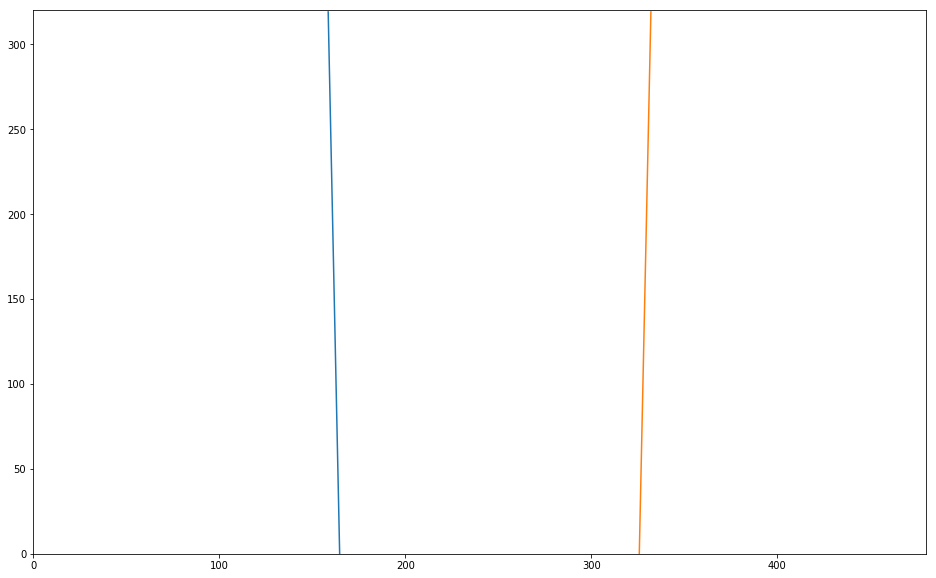

In [12]:
plt.plot(left_fitx,ploty)
plt.plot(right_fitx,ploty)

plt.xlim([0,480])
plt.ylim([0,320])
plt.show()

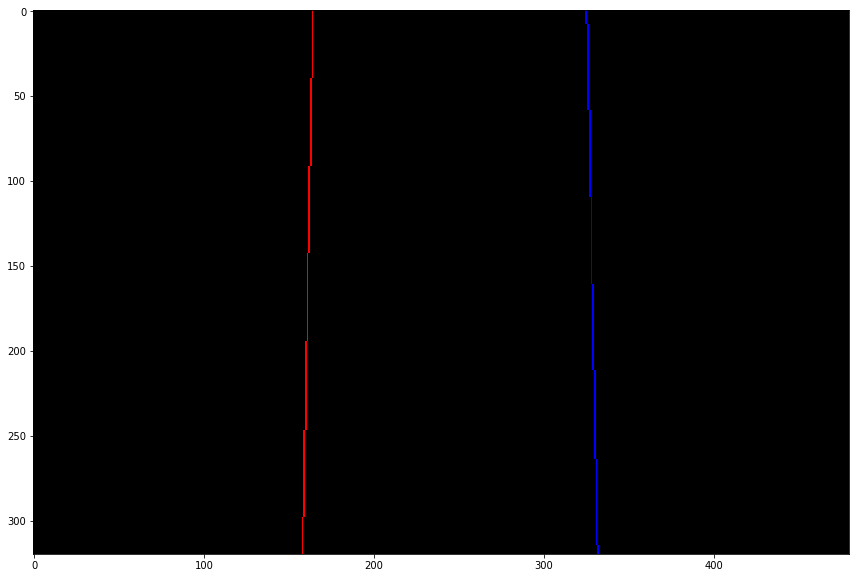

In [13]:
plot_image = np.zeros((bird_view.shape[0],bird_view.shape[1],3),np.uint8)

int_ys = np.int_(ploty)
left_int_xs = np.int_(left_fitx)
right_int_xs =  np.int_(right_fitx)

left_pts = np.transpose(np.vstack((left_int_xs,int_ys)))
right_pts = np.transpose(np.vstack((right_int_xs,int_ys)))

for left_pt in left_pts:
    x,y = left_pt
    if y < 320 and y >= 0 and x >= 0 and x < 480:
        plot_image[y][x] = [255,0,0]
        
for right_pt in right_pts:
    x,y = right_pt
    if y < 320 and y >= 0 and x >= 0 and x < 480:
        plot_image[y][x] = [0,0,255]

plt.imshow(plot_image)
plt.show()

In [14]:
def draw_lines(src_img, plot_dsize, leftx_pts, rightx_pts, ploty, color=(255, 0, 0)):
    stretch_ratio = 0.3
    
    color_image = np.zeros((plot_dsize[0],plot_dsize[1],3))

    left = np.array([np.flipud(np.transpose(np.vstack([leftx_pts,ploty])))])
    right = np.array([np.transpose(np.vstack([rightx_pts, ploty]))])
    points = np.hstack((left, right))

    cv2.fillPoly(color_image, np.int_(points), color)
    inv = inv_bird_view(color_image, stretch_ratio)
    retval = cv2.addWeighted(src_img.astype(np.uint8), 1, inv.astype(np.uint8), 1, 1)

    return retval

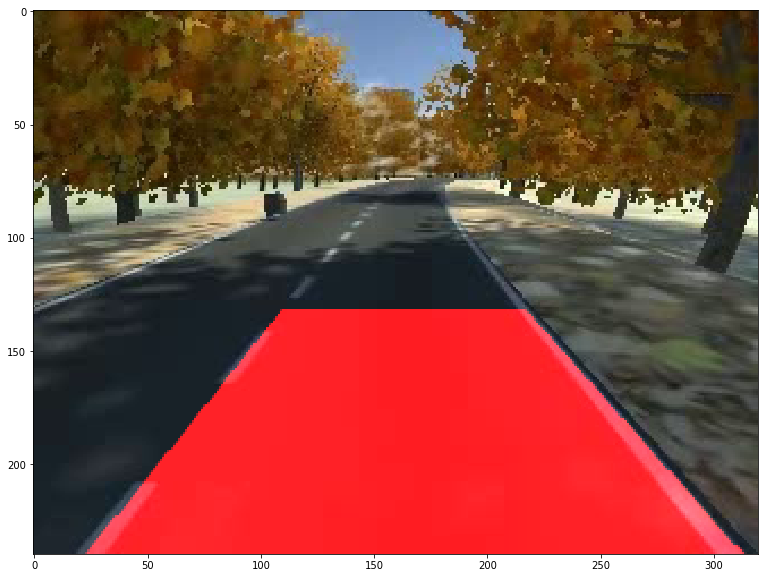

In [15]:
draw_lane = draw_lines(img,bird_view.shape[:2],left_fitx,right_fitx,ploty)
plt.imshow(draw_lane)
plt.show()